In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def cov_fn_se(x_1, x_2,alpha, rho):
    delt = (x_1 - x_2)/rho
    
    tmp = -0.5*np.dot(delt, delt)
    return (alpha**2)*np.exp(tmp)

#functions to return hessian, log lik, etc
def loglik(f,y,invK, neg = True):
    gauss_part = -0.5*np.dot(f.T,np.dot(invK,f)) #ignore normalizing constants
    lik_part = -np.log(1+np.exp((2*y-1)*f))
    ll = gauss_part+np.sum(lik_part)
    if neg:
        ll = -ll
    return ll

def loglik_g(f,y,invK,neg=True):
    prob = 1./(1+np.exp(-f))
    gauss_part = -np.dot(invK,f)
    lik_part = y-prob
    grad = lik_part + gauss_part
    if neg:
        grad = -grad
    return grad

def loglik_H(f,y,invK):
    gauss_part = -invK
    prob = 1./(1+np.exp(-f))
    lik_part = np.diag(prob*(1-prob))
    H = gauss_part - lik_part
    return H, lik_part

In [2]:
#create grid for prediction, and random inputs
x = 0.1*np.array([[x,y] for x in range(50) for y in range(50)])
x_inds = np.random.choice(x.shape[0],10,replace=True)
x_inds = np.sort(x_inds)
x_obs = x[x_inds,:]
x_obs

array([[ 0.2,  0.1],
       [ 0.2,  2.7],
       [ 1.1,  1.9],
       [ 1.2,  2. ],
       [ 1.2,  4.4],
       [ 1.5,  1.3],
       [ 2.1,  4.2],
       [ 2.9,  4.9],
       [ 3.8,  3.4],
       [ 4.2,  0.4]])

In [3]:
#build the necessary covariance matrices...
jit = 0.00001
alpha = 5.
ls = 1.

K_all = np.array([[cov_fn_se(x[i,:],x[j,:],alpha,ls) for i in range(x.shape[0])] for j in range(x.shape[0])])
K_all = K_all+jit*np.eye(K_all.shape[0])
K_obs = K_all[x_inds,:]
K_obs = K_obs[:,x_inds]
K_star = K_all[:,x_inds]



In [4]:
#invert K
invK_obs = np.linalg.inv(K_obs)


In [76]:
#star_inds = np.arange(x.shape[0])
#star_inds = np.delete(star_inds, x_inds,axis=0)
#K_starstar = K_all[star_inds,:]
#K_starstar = K_starstar[:,star_inds]
#K_star = K_all[star_inds, :]
#K_star = K_star[:,x_inds]


In [5]:
#sample a "true" function"
import matplotlib.pyplot as plt
f = np.random.multivariate_normal(np.zeros(x.shape[0]),K_all)
fp = 1./(1+np.exp(-f))
f.shape




(2500,)

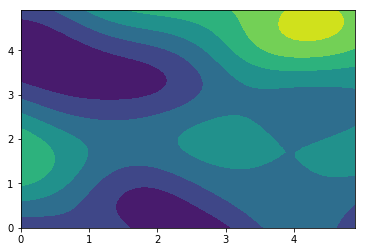

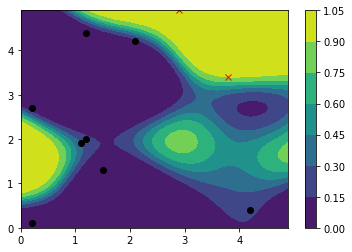

In [6]:
#plot true function and sample data
#red crosses are ones, black dots are zeros
X, Y = np.meshgrid(0.1*np.arange(50), 0.1*np.arange(50))
plt.contourf(X,Y,f.reshape(50,50).T)
plt.show()

plt.contourf(X,Y,fp.reshape(50,50).T)
plt.colorbar()

y_obs = (np.random.rand(len(x_inds))<fp[x_inds]).astype(int)
plt.plot(x_obs[y_obs==1,0],x_obs[y_obs==1,1],'rx')
plt.plot(x_obs[y_obs==0,0],x_obs[y_obs==0,1],'ko')
plt.show()

In [7]:
#initialize f to y
f = 0.5*y_obs+0.5

#optimize with Newton's method
delt = 1.
num_it = 0
while delt > 0.0001:
    prob = 1./(1+np.exp(-f))
    W = np.diag(prob*(1-prob))
    a = np.linalg.inv(invK_obs+W)
    b = np.dot(W,f) + y_obs-prob
    f_new = np.dot(a,b)
    delt = np.sum(np.abs(f-f_new))
    f = f_new+0
    num_it +=1
    print('.')
    if num_it>20:
        break
        


.
.
.
.
.
.


In [8]:
#check it's something kinda reasonable
f

array([-2.45069299, -2.77534575, -3.51799534, -3.46911069, -2.92414015,
       -3.0133831 , -1.90141169,  1.82631922,  2.33158701, -2.29378883])

In [9]:
#calculate hessian and therefore covariance of observed data
hess, W = loglik_H(f,y_obs,invK_obs)
cov_obs = np.linalg.inv(-1*hess)
#calculate mean
mean = np.dot(K_star,np.dot(invK_obs,f))

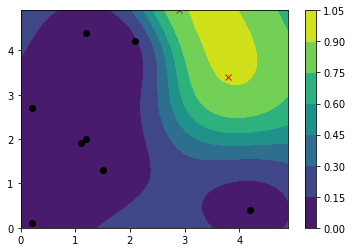

In [10]:
#plot the mean function
ppost = 1./(1+np.exp(-mean))
plt.contourf(X,Y,ppost.reshape(50,50).T)
plt.colorbar()
plt.plot(x_obs[y_obs==1,0],x_obs[y_obs==1,1],'rx')
plt.plot(x_obs[y_obs==0,0],x_obs[y_obs==0,1],'ko')
plt.show()

In [12]:
#Calculate the covariance of the predictive distribution... see 3.23-3.25 in GP book 
#I'm using all data points here in my prediction to make plotting easier
tmp = np.linalg.inv(K_obs + np.linalg.inv(W))
cov_full = K_all - np.dot(K_star,np.dot(tmp,K_star.T))



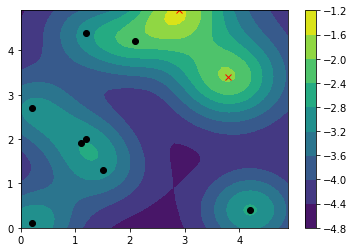

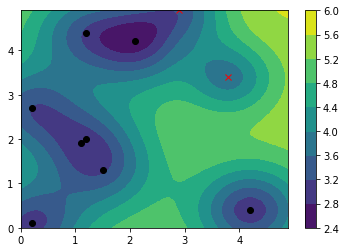

In [13]:
#plot the mean function less 1sd
ppost_less = ppost - np.sqrt(np.diag(cov_full))
plt.contourf(X,Y,ppost_less.reshape(50,50).T)
plt.colorbar()
plt.plot(x_obs[y_obs==1,0],x_obs[y_obs==1,1],'rx')
plt.plot(x_obs[y_obs==0,0],x_obs[y_obs==0,1],'ko')
plt.show()

#plot the mean function plus 1sd
ppost_more = ppost + np.sqrt(np.diag(cov_full))
plt.contourf(X,Y,ppost_more.reshape(50,50).T)
plt.colorbar()
plt.plot(x_obs[y_obs==1,0],x_obs[y_obs==1,1],'rx')
plt.plot(x_obs[y_obs==0,0],x_obs[y_obs==0,1],'ko')
plt.show()